In [34]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import pandas as pd

In [35]:
def load_zachery():
    nodes_data = pd.read_csv('https://raw.githubusercontent.com/myeonghak/DGL-tutorial/master/data/nodes.csv')
    edges_data = pd.read_csv('https://raw.githubusercontent.com/myeonghak/DGL-tutorial/master/data/edges.csv')
    src = edges_data['Src'].to_numpy()
    dst = edges_data['Dst'].to_numpy()
    g = dgl.graph((src, dst))
    club = nodes_data['Club'].to_list()
    # Convert to categorical integer values with 0 for 'Mr. Hi', 1 for 'Officer'.
    club = torch.tensor([c == 'Officer' for c in club]).long()
    # We can also convert it to one-hot encoding.
    club_onehot = F.one_hot(club)
    g.ndata.update({'club' : club, 'club_onehot' : club_onehot})
    return g

In [36]:
g = load_zachery()
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={})


In [37]:
node_embed = nn.Embedding(g.number_of_nodes(), 5)
inputs = node_embed.weight

In [38]:
nn.init.xavier_uniform_(inputs)
print(inputs)

Parameter containing:
tensor([[ 0.1314, -0.2744,  0.1272,  0.1343,  0.1711],
        [ 0.0184,  0.3910, -0.1340, -0.1818, -0.3039],
        [ 0.3126,  0.1481, -0.3868, -0.1086,  0.2797],
        [ 0.1772,  0.2551,  0.0030, -0.2449,  0.1212],
        [ 0.0028,  0.3800,  0.3572,  0.0536, -0.1536],
        [-0.3084, -0.1255,  0.3041,  0.1728, -0.3340],
        [ 0.3575, -0.3137,  0.3204,  0.3210, -0.0653],
        [ 0.0316, -0.1625,  0.1875, -0.2976, -0.2914],
        [ 0.0878, -0.1802,  0.1356, -0.2027, -0.3825],
        [ 0.0561, -0.0171, -0.1411, -0.3542, -0.3667],
        [-0.1165, -0.1819, -0.1628, -0.0866, -0.0139],
        [ 0.1730,  0.1565,  0.1033,  0.2965,  0.0066],
        [ 0.3118,  0.0134,  0.0445,  0.1191, -0.1803],
        [ 0.1952,  0.0483,  0.3513, -0.3461,  0.2103],
        [ 0.0306,  0.0841, -0.0919, -0.1195,  0.0420],
        [-0.0469, -0.0126,  0.2670, -0.3822,  0.3529],
        [-0.3054,  0.0419, -0.3065,  0.0035,  0.0474],
        [-0.2328,  0.3587,  0.2793,  0.1477

In [39]:
labels = g.ndata['club']
labeled_nodes = [0, 33]
print('Labels : ', labels[labeled_nodes])

Labels :  tensor([0, 1])


In [40]:
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, num_classes, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
    
# input layer : 5
# hidden layer : 16
# output layer : 2
net  = GraphSAGE(5, 16, 2)


In [41]:
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), node_embed.parameters()), lr=0.01)

all_logits = []
for e in range(100):
    logits = net(g, inputs)

    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels[labeled_nodes])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    all_logits.append(logits.detach())

    if e % 5 == 0: 
        print('In peoch {}, loss: {}'.format(e, loss))

In peoch 0, loss: 0.6848267316818237
In peoch 5, loss: 0.32975083589553833
In peoch 10, loss: 0.14416587352752686
In peoch 15, loss: 0.05155583471059799
In peoch 20, loss: 0.018210873007774353
In peoch 25, loss: 0.007228659465909004
In peoch 30, loss: 0.0033891310449689627
In peoch 35, loss: 0.0019133933819830418
In peoch 40, loss: 0.0012545003555715084
In peoch 45, loss: 0.0009241712396033108
In peoch 50, loss: 0.0007409420795738697
In peoch 55, loss: 0.0006300440873019397


c:\Users\di\anaconda3\envs\venv_gnn\lib\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In peoch 60, loss: 0.0005574937677010894
In peoch 65, loss: 0.0005066810408607125
In peoch 70, loss: 0.0004686736792791635
In peoch 75, loss: 0.00043846911285072565
In peoch 80, loss: 0.0004134467162657529
In peoch 85, loss: 0.0003917600552085787
In peoch 90, loss: 0.0003725156420841813
In peoch 95, loss: 0.00035499868681654334


In [42]:
pred = torch.argmax(logits, axis=1)
print('Accuracy', (pred == labels).sum().item() / len(pred))

Accuracy 0.6176470588235294


In [43]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (4.0, 3.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

In [44]:
len(all_logits)

100

RuntimeError: Requested MovieWriter (ffmpeg) not available

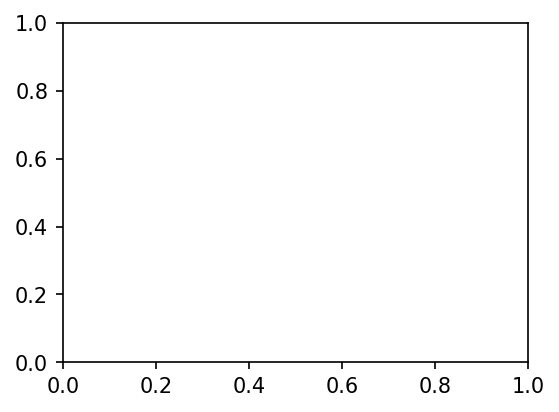

In [45]:
import networkx as nx
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = g.to_networkx()

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pred = all_logits[i].numpy()
        pos[v] = pred[v]
        cls = labels[v]
        colors.append(cls1color if cls else cls2color)
    
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=200)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())